In [1]:
# Google Colab에서 노트북을 실행하실 때에는
# https://tutorials.pytorch.kr/beginner/colab 를 참고하세요.
%matplotlib inline

In [12]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [38]:
!wget -O train_jpg.zip "https://www.dropbox.com/scl/fi/028rwo7oqnp65dopawmlu/train_jpg.zip?rlkey=nnq8nneruy5tbr09bpvm2npn7&e=1&st=dmcbq38v&dl=0"
!wget -O test_jpg.zip "https://www.dropbox.com/scl/fi/t3au3cskw5qqrk0oqrapx/test_jpg.zip?rlkey=bz2efl73db7qowde2vnuuak4w&e=1&st=pvw8qcsy&dl=0"

!unzip -oq train_jpg.zip -d train_data
!unzip -oq test_jpg.zip -d test_data


--2025-04-16 12:17:16--  https://www.dropbox.com/scl/fi/028rwo7oqnp65dopawmlu/train_jpg.zip?rlkey=nnq8nneruy5tbr09bpvm2npn7&e=1&st=dmcbq38v&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc99e8b4eabdc0ea4b3624b54d47.dl.dropboxusercontent.com/cd/0/inline/Cn7ewEUUhIjP-t8QoFt6tTr3xJNzjbl2LkDgACS2P1JMxoiKZ3MF1paHxaaCH8EH-sOPNPcDlkoxDdJYrzRuLgN3tlpJ_GE-2Pkhmkr0W58I6gQlSUO15Hl9P4U6C7c_huf_GbAgYeDVq89n44pIDMbH/file# [following]
--2025-04-16 12:17:17--  https://uc99e8b4eabdc0ea4b3624b54d47.dl.dropboxusercontent.com/cd/0/inline/Cn7ewEUUhIjP-t8QoFt6tTr3xJNzjbl2LkDgACS2P1JMxoiKZ3MF1paHxaaCH8EH-sOPNPcDlkoxDdJYrzRuLgN3tlpJ_GE-2Pkhmkr0W58I6gQlSUO15Hl9P4U6C7c_huf_GbAgYeDVq89n44pIDMbH/file
Resolving uc99e8b4eabdc0ea4b3624b54d47.dl.dropboxusercontent.com (uc99e8b4eabdc0ea4b3624b54d47.dl.dropboxusercontent.com)..

In [41]:
!ls train_data
!ls test_data

train
test


In [44]:
def count_images_per_class(root_dir, exts={'.jpg', '.jpeg', '.png', '.heic'}):
    result = {}
    total = 0
    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            count = 0
            for fname in os.listdir(class_path):
                if os.path.splitext(fname)[1].lower() in exts:
                    count += 1
            result[class_name] = count
            total += count
    return result, total

In [45]:
train_counts, train_total = count_images_per_class('train_data/train')
test_counts, test_total = count_images_per_class('test_data/test')

print("▶ Train 이미지 개수:")
for k, v in train_counts.items():
    print(f" - 클래스 {k} : {v}장")
print(f"✅ Train 전체 총합: {train_total}장")

print("\n▶ Test 이미지 개수:")
for k, v in test_counts.items():
    print(f" - 클래스 {k} : {v}장")
print(f"✅ Test 전체 총합: {test_total}장")


▶ Train 이미지 개수:
 - 클래스 1 : 70장
 - 클래스 10 : 137장
 - 클래스 2 : 70장
 - 클래스 3 : 76장
 - 클래스 4 : 70장
 - 클래스 5 : 74장
 - 클래스 6 : 70장
 - 클래스 7 : 70장
 - 클래스 8 : 70장
 - 클래스 9 : 70장
✅ Train 전체 총합: 777장

▶ Test 이미지 개수:
 - 클래스 1 : 30장
 - 클래스 10 : 66장
 - 클래스 2 : 30장
 - 클래스 3 : 24장
 - 클래스 4 : 30장
 - 클래스 5 : 30장
 - 클래스 6 : 30장
 - 클래스 7 : 30장
 - 클래스 8 : 30장
 - 클래스 9 : 30장
✅ Test 전체 총합: 330장


In [47]:
import os
import numpy as np
from PIL import Image

def load_image_dataset(root_dir, image_size=(224, 224), exts={'.jpg', '.jpeg', '.png'}):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    class_to_index = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(root_dir, class_name)
        for fname in os.listdir(class_path):
            if os.path.splitext(fname)[1].lower() in exts:
                img_path = os.path.join(class_path, fname)
                try:
                    img = Image.open(img_path).convert("RGB").resize(image_size)
                    img_array = np.array(img) / 255.0  # 정규화
                    images.append(img_array)
                    labels.append(class_to_index[class_name])
                except Exception as e:
                    print(f"❌ 이미지 오류: {img_path} ({e})")

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32), class_names

In [48]:
# Train 이미지 로드
train_images, train_labels, class_names = load_image_dataset("train_data/train")

# Test 이미지 로드
test_images, test_labels, _ = load_image_dataset("test_data/test")

# 확인
print("train_images.shape:", train_images.shape)
print("train_labels.shape:", train_labels.shape)
print("class_names:", class_names)


train_images.shape: (777, 224, 224, 3)
train_labels.shape: (777,)
class_names: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


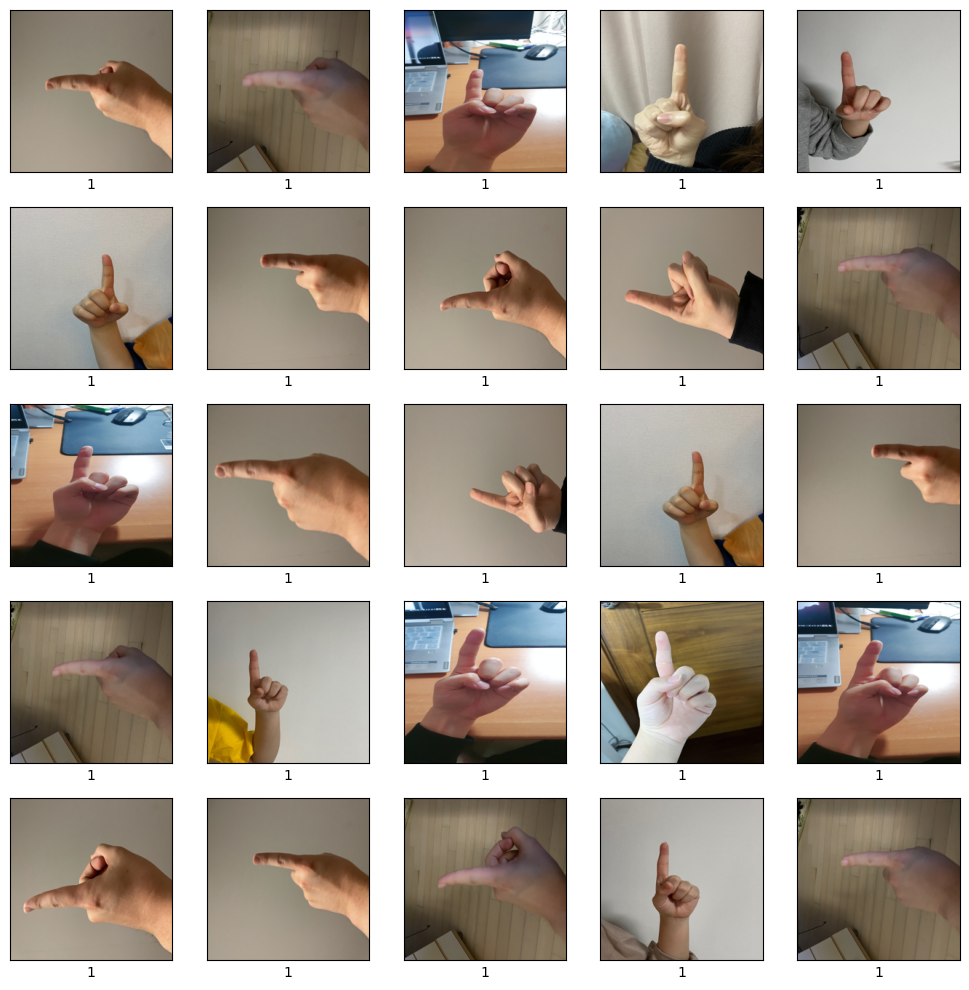

In [49]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])  # RGB이므로 cmap 생략
    plt.xlabel(class_names[train_labels[i]])
plt.tight_layout()
plt.show()

In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 이미지를 28x28 그레이스케일로 리사이즈
def resize_and_grayscale(images):
    resized = tf.image.resize(images, [28, 28])
    gray = tf.image.rgb_to_grayscale(resized)  # (28,28,1)
    return gray.numpy()

train_images_resized = resize_and_grayscale(train_images)
test_images_resized = resize_and_grayscale(test_images)

print("변환 후 train 이미지:", train_images_resized.shape)

변환 후 train 이미지: (777, 28, 28, 1)


In [54]:
model = models.Sequential([
    layers.Reshape((28, 28, 1), input_shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images_resized, train_labels, epochs=10, validation_split=0.2)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.1784 - loss: 2.2147 - val_accuracy: 0.0000e+00 - val_loss: 4.8761
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1907 - loss: 2.0848 - val_accuracy: 0.0000e+00 - val_loss: 5.7120
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2315 - loss: 2.0536 - val_accuracy: 0.0000e+00 - val_loss: 5.5582
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2338 - loss: 2.0367 - val_accuracy: 0.0000e+00 - val_loss: 5.5452
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.2145 - loss: 2.0380 - val_accuracy: 0.0000e+00 - val_loss: 6.3827
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2098 - loss: 2.0324 - val_accuracy: 0.0000e+00 - val_loss: 6.1647
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2177 - loss: 1.9872 - val_accuracy: 0.0000e+00 - val_loss: 6.7373
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2536 - loss: 1.941

In [57]:
history = model.fit(train_images_resized, train_labels, epochs=10,
                    validation_data=(test_images_resized, test_labels))

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.2621 - loss: 2.4531 - val_accuracy: 0.2121 - val_loss: 2.2296
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.2647 - loss: 2.0054 - val_accuracy: 0.1758 - val_loss: 2.3027
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3183 - loss: 1.8445 - val_accuracy: 0.2030 - val_loss: 2.4502
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3866 - loss: 1.6775 - val_accuracy: 0.1758 - val_loss: 2.4384
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.4342 - loss: 1.5608 - val_accuracy: 0.1758 - val_loss: 2.3924
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4792 - loss: 1.4783 - val_accuracy: 0.2152 - val_loss: 2.3184
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5527 - loss: 1.3278 - val_accuracy: 0.2394 - val_loss: 2.4044
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5763 - loss: 1.2568 - val_accuracy: 0.2273 - v

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# EarlyStopping 설정: 3 epoch 동안 성능 개선 없으면 중단
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ModelCheckpoint 설정: 최적의 모델 저장
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

In [59]:
history = model.fit(train_images_resized, train_labels,
                    epochs=20,
                    validation_data=(test_images_resized, test_labels),
                    callbacks=[early_stop, checkpoint])

Epoch 1/20
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6930 - loss: 0.9314
Epoch 1: val_loss improved from inf to 2.50016, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6914 - loss: 0.9338 - val_accuracy: 0.2333 - val_loss: 2.5002
Epoch 2/20
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6871 - loss: 0.9533
Epoch 2: val_loss improved from 2.50016 to 2.48010, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6873 - loss: 0.9504 - val_accuracy: 0.2576 - val_loss: 2.4801
Epoch 3/20
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7366 - loss: 0.8539
Epoch 3: val_loss did not improve from 2.48010
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7353 - loss: 0.8528 - val_accuracy: 0.2364 - val_loss: 2.6771
Epoch 4/20
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7018 - loss: 0.8280
Epoch 4: val_loss did not improve from 2.48010
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 

In [60]:
# 최적의 모델 다시 로드
best_model = tf.keras.models.load_model('best_model.keras')

# 모델 평가 (Grayscale, 28x28x1로 변환된 test 이미지 사용)
loss, acc = best_model.evaluate(test_images_resized, test_labels)

print(f"✅ Best model accuracy: {acc:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2942 - loss: 2.1327
✅ Best model accuracy: 0.2576


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


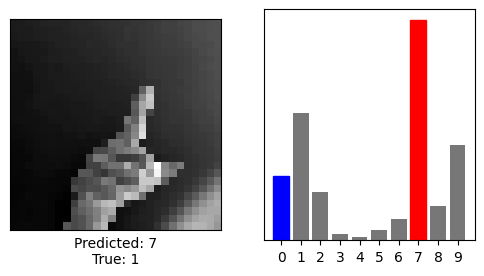

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# 예측 수행
predictions = best_model.predict(test_images_resized)

# 첫 번째 이미지의 예측 결과 시각화
plt.figure(figsize=(6, 3))

# 1. 이미지 보여주기
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(test_images_resized[0].squeeze(), cmap=plt.cm.binary)  # grayscale이므로 squeeze

predicted_label = np.argmax(predictions[0])
true_label = test_labels[0]

plt.xlabel(f"Predicted: {class_names[predicted_label]}\nTrue: {class_names[true_label]}")

# 2. 확률 bar chart
plt.subplot(1, 2, 2)
plt.grid(False)
plt.xticks(range(10))
plt.yticks([])
bar_plot = plt.bar(range(10), predictions[0], color="#777777")
bar_plot[predicted_label].set_color('red')
bar_plot[true_label].set_color('blue')

plt.show()